# Confidence formulas

In [4]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
from scipy.stats import binom, norm, beta 
from scipy.optimize import root_scalar  

## Base model

### Exact resolution

If we have $n$ pulls per arm, one law $Y_1$ of success probability $\theta_1$, one law $Y_2$ of success probability $\theta_2$, then the probability that the second recommendation algorithm is more successful than the first one is

$$\sum_{k=0}^{n}\,\mathbb{P}(Y_1=k)\mathbb{P}(Y_2\ge k),$$

because, with $n$ pulls, the number of successes $k$ goes from 0 to $n$.

In [5]:
# We compute the exact probability to have an error
n = 10**4
θ1 = .05
θ2 = .045

# Probability mass function from binom of scipy.stats; survival function = 1-cdf but sometimes more accurate;
# We compute the series above
np.array([binom.pmf(k, n, θ1) for k in range(n+1)]) @ np.array([binom.sf(k, n, θ2) for k in range(n+1)]) 

0.04653681048355371

Using this formula, one can devise a function that associates to given $n$, $\theta_1$, and $\epsilon$ the gap $\theta_1-\theta_2$ for which the error probability is $\epsilon$. 

This is done by finding the value of $\theta_2$ that achieves the condition through root-finding. 
By specifying a bracket, we ask to find the root of the scalar function via one of the bracketing methods (bisection method, Brent's method, ...). The one generally applied is Brent’s method, which guarantees convergence (Brent, 1973 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brentq.html) for functions computable within the bracket's interval by combining bisection with interpolation.

In [6]:
ϵ = .1

def exact_ground(n=n, θ=θ1, ϵ=ϵ):
    
    # Nested function where the probability of success for Y2 is x instead of θ2
    def f(x):
        prob = np.array([binom.pmf(k, n, θ) for k in range(int(n+1))]) @ np.array([binom.sf(k, n, x) for k in range(int(n+1))])
        return prob-ϵ

    # Root finding
    r = root_scalar(f, bracket=[.001, .99])  # root_scalar from scipy.optimize

    # Convergence check
    if r.converged:
        return θ - r.root       #required gap
    else:
        print(r)                # error message (result in case of no-convergence)

We choose bracket $[.001, .99]$ instead of $[0,1]$ because the integration (see Section 2.1) would suffer inconsistencies for some parameters (e.g. the numerical result strongly differs from what it should be).

In [7]:
# Example
exact_ground()

# for 10000 samples and a 99% confidence, the gap must be at least .7%
# for 10000 samples and a 95% confidence, the gap must be at least .490%

# Arianna:  (by taking both CTR 5%) for 10000 samples and a 95% confidence, the gap must be at least .507%

0.0038267601963568043

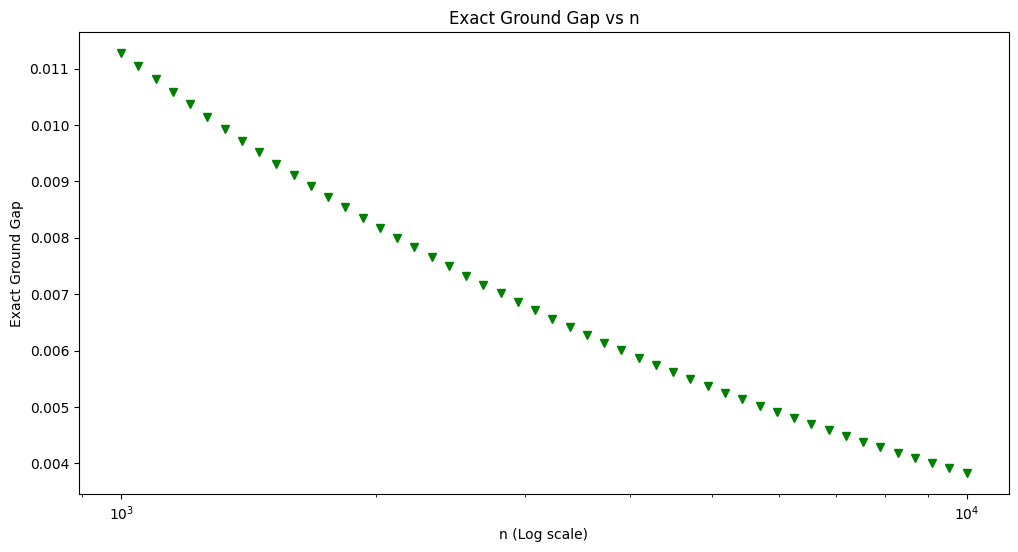

In [8]:
# Generate logarithmically spaced values for n  
n_values = [int(i) for i in np.logspace(3, 4)]
exact_ground_values = []

# Evaluate the exact_ground function for each value of n
for n in n_values:                                                   # To speed up, list comprehension could be used in alternative to for loop  
    exact_ground_values.append(exact_ground(n))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(n_values, exact_ground_values, 'gv')
plt.xscale('log')  # Use logarithmic scale for the x-axis
plt.xlabel('n (Log scale)')
plt.ylabel('Exact Ground Gap')
plt.title('Exact Ground Gap vs n')
plt.show()

#### Homemade bisection (alternative to root_scalar)

In [9]:
def dicho_solver(f, ϵ, n_iter=20):
    """find x such that f(x)=ϵ, assuming monotonicity, f(0)=0, f(1)=1"""
    l = 0
    h = 1
    x = (l+h)/2
    for _ in range(n_iter):
        fx = f(x)
        #print(f"x={x} => f(x)={fx}")
        if fx > ϵ:
            h = x
        else:
            l = x
        x = (l+h) /2
    return x

In [10]:
def my_exact_ground(n=n, θ=θ1, ϵ=ϵ):
    def f(x):
        return np.array([binom.pmf(k, n, θ) for k in range(n+1)])@np.array([binom.sf(k, n, x) for k in range(n+1)])
    return θ - dicho_solver(f, ϵ)

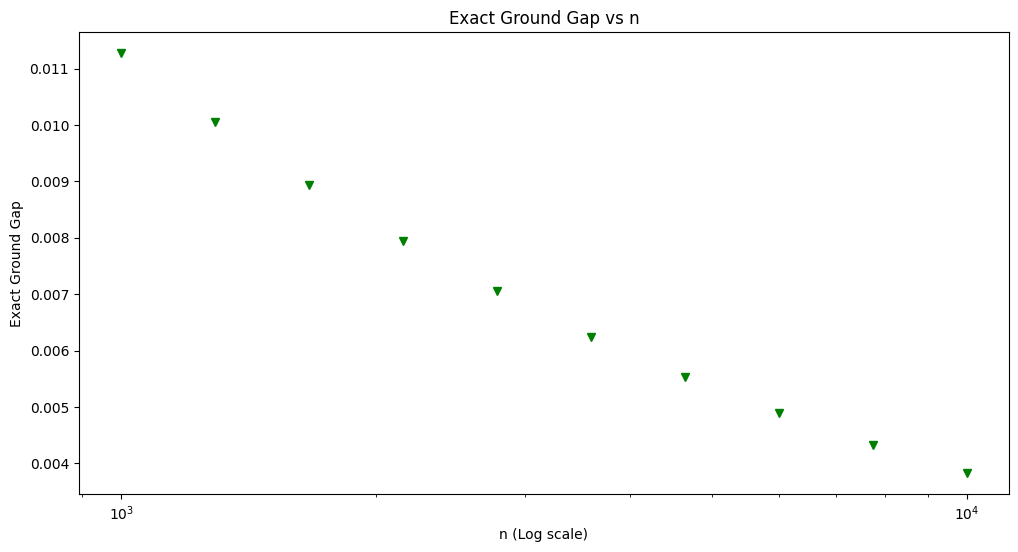

In [11]:
# Generate logarithmically spaced values for n
n_values = [int(i) for i in np.logspace(3, 4, 10)]
exact_ground_values = []

# Evaluate the exact_ground function for each value of n
for n in n_values:
    exact_ground_values.append(my_exact_ground(n))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(n_values, exact_ground_values, 'gv')
plt.xscale('log')  # Use logarithmic scale for the x-axis
plt.xlabel('n (Log scale)')
plt.ylabel('Exact Ground Gap')
plt.title('Exact Ground Gap vs n')
plt.show()

### Gaussian approximation

This is very slow. To speed things up, one can use the Gaussian approximation

$$\epsilon \approx \Phi\left((\theta_2-\theta_1)\sqrt{\frac{n}{\theta_1(1-\theta_1)+\theta_2(1-\theta_2)}}\right)$$

(see pdf for details).

In [12]:
def ground(n=10**4, θ=.05, ϵ=.01):

    # Nested function to look for the x for which the cdf equals ϵ
    def f(x):
        return norm.cdf((x-θ) * np.sqrt(n/(θ*(1-θ)+x*(1-x)))) - ϵ

    # Root finding
    r = root_scalar(f, bracket=[0, 1])
    
    # Convergence check
    if r.converged:
        return θ - r.root
    else:
        print(r)

In [13]:
# example
ground(n=10**4, θ=.05, ϵ=.01)
# for 10000 samples and a 99% confidence, the gap must be at least .7%

0.006929073961528545

Much faster. There is a small error but it's worth it.

## Bayesian approach (a.k.a. variant #3)

### Exact resolution (Beta integration)

Now we consider the problem from the other angle: given observations $a_1, b_1, a_2, b_2 $, we assume that the ground truth success probabilities $\theta_1$ and $\theta_2$ are actually random variables following beta distribution $\beta(a_1, b_1)$ and $\beta(a_2, b_2)$ respectively.

Then, the probability to have $\theta_2>\theta_1$ is

$$\int_0^1f_2(y)\int_0^y f_1(x)dx\,dy,$$
where $f_1$ and $f_2$ are the density functions.

In [15]:
# Check that the distributions overlap

# Parameters for Beta distributions
a1, b1 = 500, 9500  # Parameters for .05 = θ1 ~ Beta(a1, b1)  
a2, b2 = 450, 9550  # Parameters for θ2 ~ Beta(a2, b2)

n_beta= 10**5
theta1_hat_samples = np.random.beta(a1, b1, n_beta)
theta2_hat_samples = np.random.beta(a2, b2, n_beta)

sum(theta2_hat_samples > theta1_hat_samples) / len(theta1_hat_samples)

0.04834

In [16]:
# First attempt at computing the empirical error (e.g. probability that the ground truth does not match the observation)
# We use a double integral, which is quite slow

import scipy.stats as stats
from scipy.integrate import dblquad  # double definite integral 

# Parameters for Beta distributions
a1, b1 = 500, 9500 
a2, b2 = 450, 9550 

# Define the joint PDF for the region where θ1 < θ2
def joint_pdf(y1, y2):
    
    # PDF of Y1 ~ Beta(a1, b1)
    pdf_y1 = stats.beta.pdf(y1, a1, b1)
    
    # PDF of Y2 ~ Beta(a2, b2)
    pdf_y2 = stats.beta.pdf(y2, a2, b2)
    
    # Joint PDF is the product of individual PDFs since θ1 and θ2 are independent
    return pdf_y1 * pdf_y2

# Perform the double integration: pdf_y2 integrated in [0,1], pdf_y1 integrated in [0, y2]
probability, error = dblquad(joint_pdf, 0, 1, lambda y2: 0, lambda y2: y2)

print("Estimated P(Y_2 > Y_1) by numerical integration:", probability)
print("Integration error estimate:", error)

Estimated P(Y_2 > Y_1) by numerical integration: 0.04813209362438512
Integration error estimate: 8.920181489291412e-08


In [17]:
# Second attempt using the cdf and a simple integral. Much faster and precise: we use this one

import scipy.stats as stats
from scipy.integrate import quad  # Integration technique from the Fortran library QUADPACK

# Parameters for Beta distributions
a1, b1 = 500, 9500      
a2, b2 = 450, 9550 

def my_pdf(y2):
    return stats.beta.cdf(y2, a1, b1) * stats.beta.pdf(y2, a2, b2)

# Perform the double integration
probability, error = quad(my_pdf, 0, 1)  # Simple integral 

print("Estimated P(Y_2 > Y_1) by numerical integration:", probability)
print("Integration error estimate:", error)

Estimated P(Y_2 > Y_1) by numerical integration: 0.04813209362438567
Integration error estimate: 7.990628016373209e-11


In [18]:
# Probability of misestimating the ground truth from the observed values (as ground but the other way round)

def empirical(n=10**4, θ=.05, ϵ=.01):

    # Nested function to find a1,b1,a2,b2 based on n,x
    def f(x):                 
        a1 = n * θ   # successes
        b1 = n - a1  # failures
        a2 = n * x
        b2 = n - a2
        pdf = lambda y2: stats.beta.cdf(y2, a1, b1) * stats.beta.pdf(y2, a2, b2)
        probability, error = quad(pdf, 0, 1)
        return probability-ϵ

    # Root finding
    r = root_scalar(f, bracket=[.001, .99])
    
    # Convergence check (just fof safety, because if there are no previous issues, the BRACKETING method will always converge)
    if r.converged:
        return θ - r.root
    else:
        print(r)

For large $n$, integrating the function $f$ (nested in "empirical") with quad would give some problems. Through a manual dichotomy, we see that the integral sometimes fails because the curve is too sharp, so $f$ is not monotonic.

$f$ measures the probability of error as a function of $\theta_2$, and the goal is to spot when it goes to $\epsilon$. It is supposed to be monotonic but the numerical evaluation sometimes glitches from 1 to 0 and back.
The discrepancies seem to be related to (negative) powers of two, when $n$ is large. If, 
while solving $f(x)-\epsilon=0$, 
one of the faulty values is computed, then the solver fails or returns something not consistent.

For the same reason, we trust the exact beta computation just for $n \leq 10^4$; because of the numerical precision issues, it would be difficult to run it for larger values of $n$.

In [19]:
empirical()

0.006924135248940012

In [20]:
ground()

0.006929073961528545

### Normal approximation

It's actually the same than for the base model (CLT with same mean and standard deviation).

### Comparison with base model for different window sizes

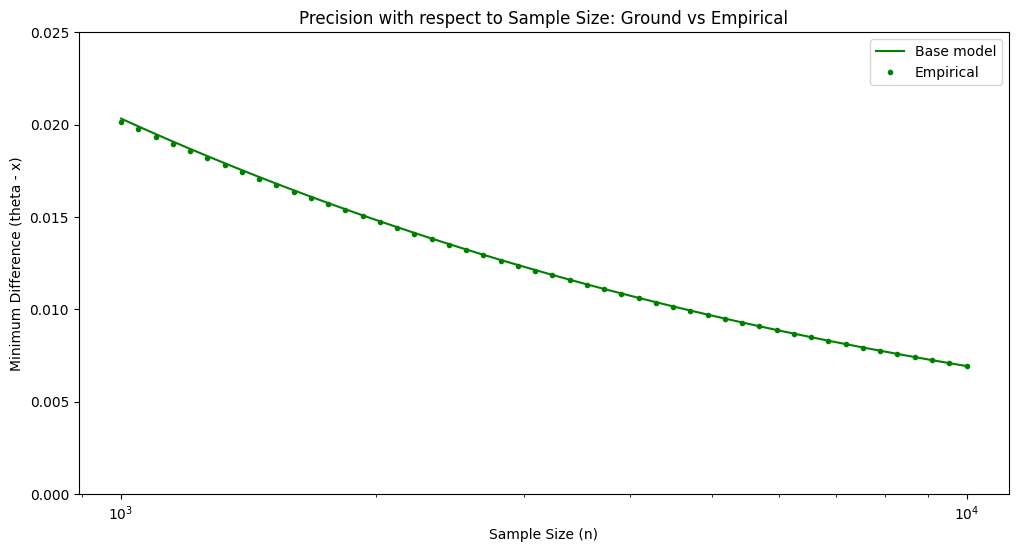

In [21]:
"""
Parameters:
    n_range (iterable): Range of n values for the x-axis.
    theta (float): True success rate (probability of success).
    epsilon (float): Confidence level.
"""

n_range = np.logspace(3, 4)    # As we trust only n <= 10**4
θ=.05
ϵ=.01

# Compute values for each method
min_diff_ground = []
min_diff_empirical = []

# Precision for base model 
for n in n_range:
    min_diff_ground.append(ground(n, θ, ϵ))

# Precision for Bayesian approach
for n in n_range:
    min_diff_empirical.append(empirical(n, θ, ϵ))

# Plot results
plt.figure(figsize=(12, 6))
plt.ylim(0, 0.025)
plt.semilogx(n_range, min_diff_ground, 'g-', label="Base model")
plt.semilogx(n_range, min_diff_empirical, 'g.', label="Empirical")
plt.xlabel("Sample Size (n)")
plt.ylabel("Minimum Difference (theta - x)")
plt.title("Precision with respect to Sample Size: Ground vs Empirical")
#plt.title(f"Precision with respect to Sample Size: Ground vs Empirical (theta={θ}, epsilon={ϵ})")
plt.legend()
plt.show()

We consider np.logspace(3, 4) beacause e.g. for n=10**5 the bracket [0.001, 0.99] f rises an error because f assumes different signs at the extremes. 
Then, the interval may no longer contain a root (cfr. bisection).

As expected, the results are essentially the same. In this case, for small window sizes the empirical method performed a little better.

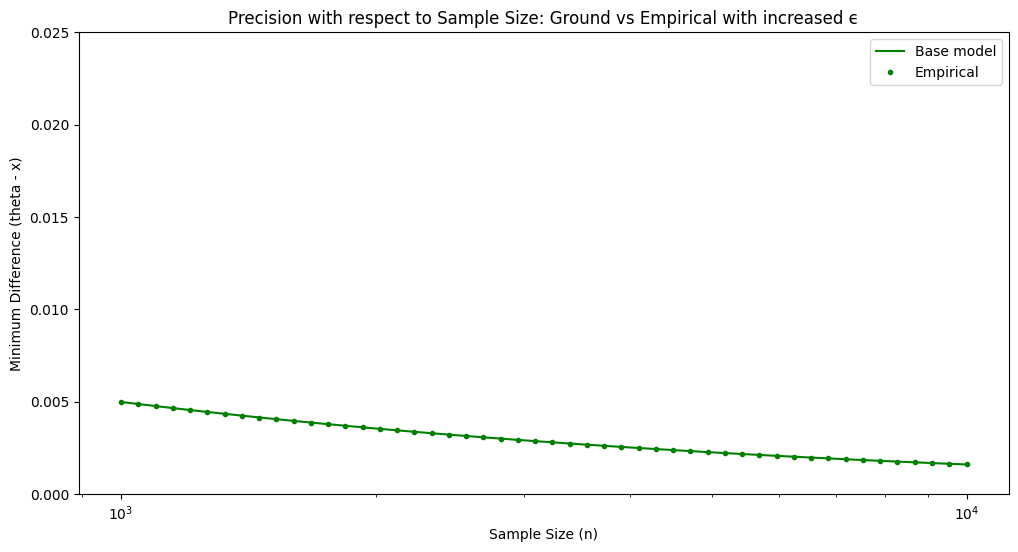

In [23]:
n_range = np.logspace(3, 4)
θ=.05
ϵ=.3  # INCREASED threshold

# Compute values for each method
min_diff_ground = []
min_diff_empirical = []

# Precision for base model 
for n in n_range:
    min_diff_ground.append(ground(n, θ, ϵ))

# Precision for Bayesian approach
for n in n_range:
    min_diff_empirical.append(empirical(n, θ, ϵ))

# Plot results
plt.figure(figsize=(12, 6))
plt.ylim(0, 0.025)
plt.semilogx(n_range, min_diff_ground, 'g-', label="Base model")
plt.semilogx(n_range, min_diff_empirical, 'g.', label="Empirical")
plt.xlabel("Sample Size (n)")
plt.ylabel("Minimum Difference (theta - x)")
plt.title("Precision with respect to Sample Size: Ground vs Empirical with increased ϵ")
#plt.title(f"Precision with respect to Sample Size: Ground vs Empirical (theta={θ}, epsilon={ϵ})")
plt.legend()
plt.show()

By inceasing the desired confidence threshold within ]0, 0.5[, the curves flatten more and more, as precision decreased.
The gap between base model and the approxiamtion seems decreasing, so that the curves appear almost undistinguishable.

## Final results

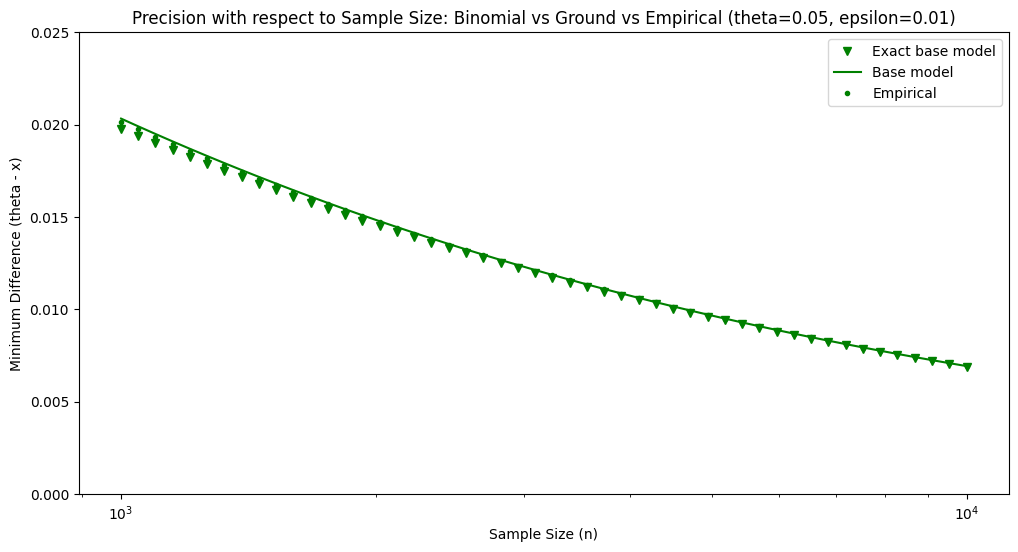

In [24]:
# Exact Binomial, exact Beta, and the Gaussian approximation 

n_range = [int(i) for i in np.logspace(3, 4)]   # As we trust only n <= 10**4, we use range [10**3, 10**4]; int() necessary because of exact_ground
θ=.05
ϵ=.01

# Compute values for each method
min_diff_exactground = []
min_diff_ground = []
min_diff_empirical = []

# Precision for exact Binomial 
for n in n_range:
    min_diff_exactground.append(exact_ground(n, θ, ϵ))

# Precision for Gaussian approximation 
for n in n_range:
    min_diff_ground.append(ground(n, θ, ϵ))

# Precision for exact Beta 
for n in n_range:
    min_diff_empirical.append(empirical(n, θ, ϵ))

# Plot results
plt.figure(figsize=(12, 6))
plt.ylim(0, 0.025)
plt.semilogx(n_range, min_diff_exactground, 'gv', label="Exact base model")
plt.semilogx(n_range, min_diff_ground, 'g-', label="Base model")
plt.semilogx(n_range, min_diff_empirical, 'g.', label="Empirical")
plt.xlabel("Sample Size (n)")
plt.ylabel("Minimum Difference (theta - x)")
plt.title(f"Precision with respect to Sample Size: Binomial vs Ground vs Empirical (theta={θ}, epsilon={ϵ})")
plt.legend()
plt.show()

We conclude that Binomial and Beta give the same values than the Gaussian approximation. 

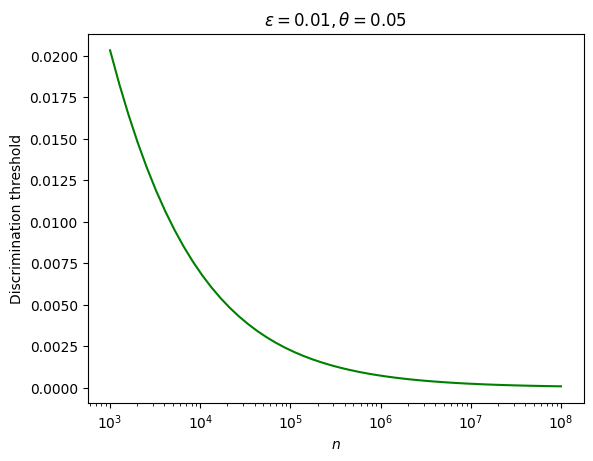

In [25]:
# Graph with only the Gaussian approximation 

# Generate logarithmically spaced values
xx = np.logspace(3, 8)  # Values from 10^3 to 10^8 bc 10**2 gives error  
# Parameters for the ground function
θ = .05
ε = .01

# Evaluate the function for all values of xx
yy = [ground(n=x, θ=θ, ε=ε) for x in xx]

# Plot the results
plt.semilogx(xx, yy, 'g') 
#plt.xlim([10**3, 10**8])  # Set x-axis limits
plt.xlabel('$n$')  
plt.ylabel('Discrimination threshold') ##
plt.title(f"$ε={ε}, θ={θ}$")  
plt.show()

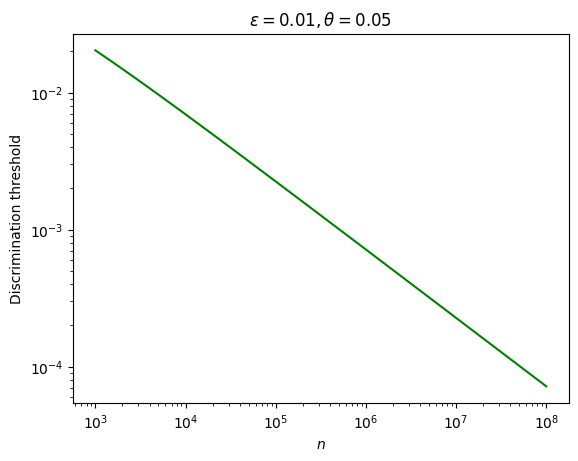

In [26]:
# Log-log plot as the 1/sqrt(n) dependency yields a straight line

# Generate logarithmically spaced values
xx = np.logspace(3, 8)  # Values from 10^3 to 10^8   
# Parameters for the ground function
θ = .05
ε = .01

# Evaluate the function for all values of xx
yy = [ground(n=x, θ=θ, ε=ε) for x in xx]

# Plot the results
plt.loglog(xx, yy, 'g')  
#plt.xlim([10**3, 10**8])  # Set x-axis limits
plt.xlabel('$n$')  
plt.ylabel('Discrimination threshold') ##
plt.title(f"$ε={ε}, θ={θ}$")  
plt.show()

Also, by plotting the Gaussian approximation alone we can retrieve values over greater values of $n$ (e.g. $10^4, ..., 10^8$).